In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from astropy import convolution
from skimage import restoration
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf

In [2]:
# directory where default PSFs live
psf_dir = os.path.join(repo_dir, 'mejiro', 'data', 'default_psfs')

In [3]:
# open pickled lens dict list
f106_list = util.unpickle_all(config.machine.dir_03, prefix='lens_dict_*_f106', limit=9)
f129_list = util.unpickle_all(config.machine.dir_03, prefix='lens_dict_*_f129', limit=9)
f184_list = util.unpickle_all(config.machine.dir_03, prefix='lens_dict_*_f184', limit=9)
dict_list = []
for i, _ in enumerate(f106_list):
    dict_list.append((f106_list[i], f129_list[i], f184_list[i]))

In [4]:
pipeline_params = util.hydra_to_dict(config.pipeline)

In [5]:
lens_dict = f106_list[0]

In [6]:
# unpack pipeline_params
max_scene_size = pipeline_params['max_scene_size']
num_samples = pipeline_params['num_samples']
oversample = pipeline_params['grid_oversample']

# get parameters for off-axis PSF
instrument = psf.get_instrument('F106')
x, y = psf.get_random_position(suppress_output=False)
detector = psf.get_random_detector(instrument, suppress_output=False)

# unpack lens_dict
array = lens_dict['model']
lens = lens_dict['lens']
uid = lens.uid
band = lens.band

Detector position: 1882, 2045
Detector: SCA02


100%|██████████| 698/698 [00:04<00:00, 163.12it/s]


Point source conversion complete: placed 698 point sources
Estimated calculation time: 0:00:55
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:45


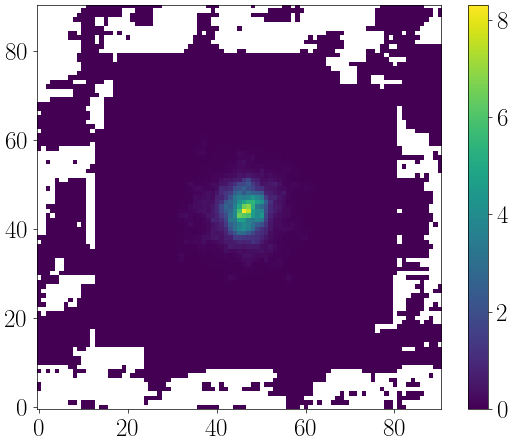

In [7]:
# generate Pandeia image with no background or noise
calc_off, _ = pandeia_input.build_pandeia_calc(deepcopy(array), 
                                        deepcopy(lens), 
                                        background=False, 
                                        noise=False, 
                                        band=band, 
                                        max_scene_size=max_scene_size,
                                        num_samples=num_samples, 
                                        suppress_output=False)
pandeia_off, _ = pandeia_input.get_pandeia_image(calc_off, suppress_output=False)

plot.plot(pandeia_off, colorbar=True)

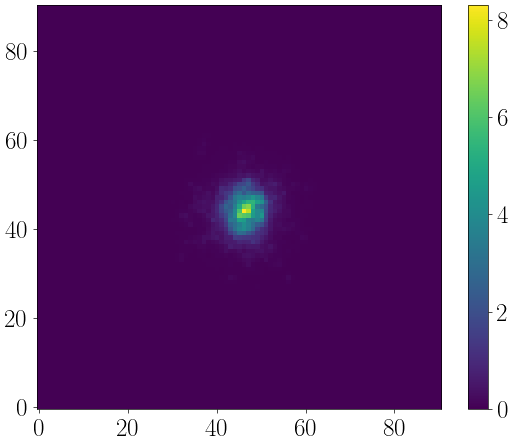

In [8]:
pandeia_off = np.nan_to_num(pandeia_off, copy=False, nan=0)

plot.plot(pandeia_off, colorbar=True)

  0%|          | 0/697 [00:00<?, ?it/s]

100%|██████████| 697/697 [00:04<00:00, 163.19it/s]


Point source conversion complete: placed 697 point sources
Estimated calculation time: 0:00:55
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:46


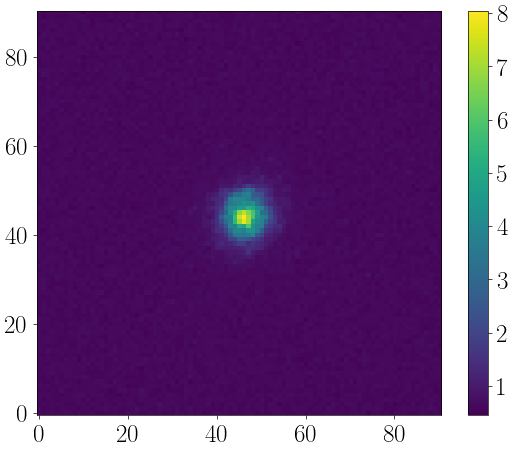

In [9]:
# generate Pandeia image with background and noise
calc_on, _ = pandeia_input.build_pandeia_calc(deepcopy(array), 
                                        deepcopy(lens), 
                                        background=True, 
                                        noise=True,
                                        band=band, 
                                        max_scene_size=max_scene_size,  
                                        num_samples=num_samples, 
                                        suppress_output=False)
pandeia_on, _ = pandeia_input.get_pandeia_image(calc_on, suppress_output=False)

plot.plot(pandeia_on, colorbar=True)

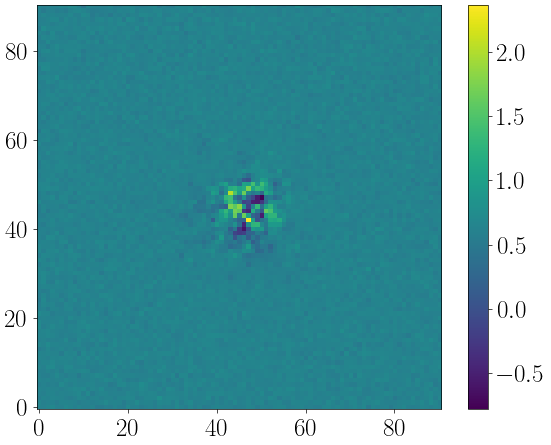

In [10]:
# subtract to get noise and convolved sky background
noise_and_convolved_bkg = pandeia_on - pandeia_off

plot.plot(noise_and_convolved_bkg, colorbar=True)

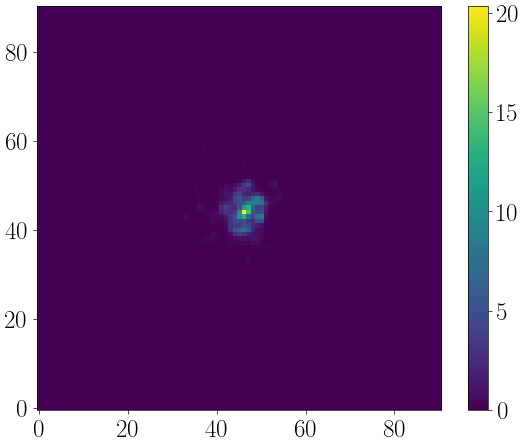

In [11]:
# deconvolve the "nothing on" image to get synthetic image in Pandeia units
default_kernel = psf.load_default_psf(psf_dir, band, oversample)
deconvolved = restoration.richardson_lucy(pandeia_off, 
                                        default_kernel, 
                                        num_iter=30, 
                                        clip=False)

plot.plot(deconvolved, colorbar=True)

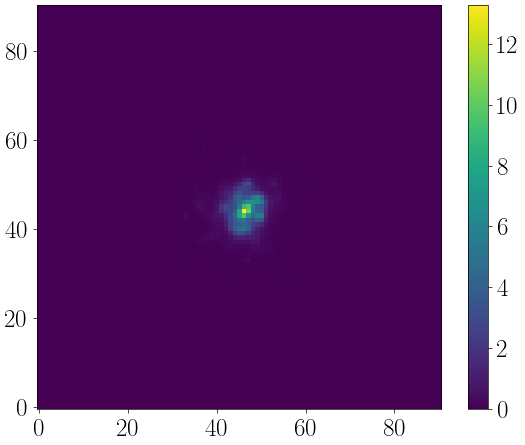

In [12]:
# re-convolve with off-axis PSF
off_axis_kernel = psf.get_psf_kernel(band=band, 
                                    x=x, 
                                    y=y, 
                                    detector=detector, 
                                    oversample=oversample, 
                                    suppress_output=False)
off_axis_image = convolution.convolve(deconvolved, off_axis_kernel)

plot.plot(off_axis_image, colorbar=True)

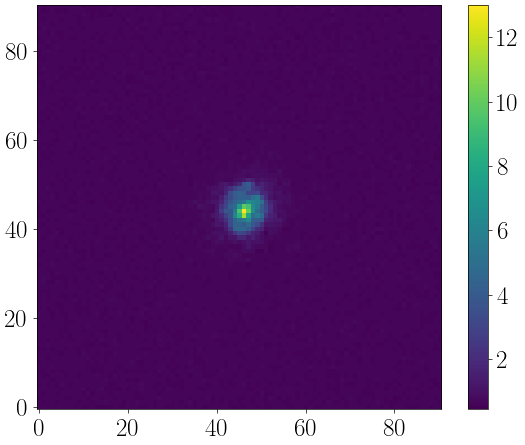

In [13]:
# add off-axis image and noise+convolved bkg
final_image = off_axis_image + noise_and_convolved_bkg

plot.plot(final_image, colorbar=True)

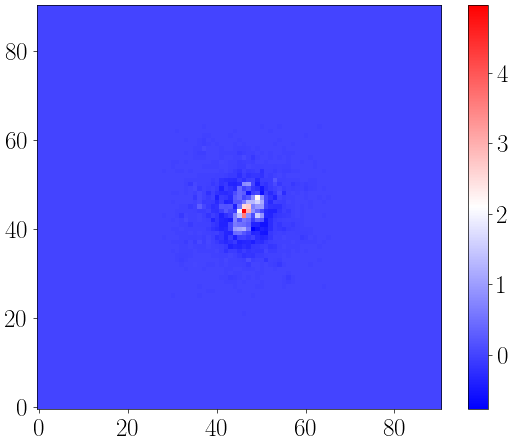

In [14]:
# also save residual
residual = final_image - pandeia_on

plot.plot(residual, colorbar=True, cmap='bwr')